In [1]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200
%sql trino://localhost:9090/cuebiq/

'Connected: @cuebiq/'

In [51]:
schema = 'ds_data_for_complexity'
q = f"""show tables from dedicated.{schema}"""
%sql $q

stops_table_name = f'dedicated.{schema}.selected_stops_limited'
device_location_table_name = f'dedicated.{schema}.device_location_and_stops_limited'

query = f"""
with stops as(
    SELECT *
    FROM {stops_table_name}
),

events_ AS (
    SELECT *,
           LAG(stop_start_unix_timestamp) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY zoned_datetime) AS prev_stop_start_unix_timestamp,
           LAG(stop_end_unix_timestamp) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY zoned_datetime) AS prev_stop_end_unix_timestamp,
           LAG(zoned_datetime) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY stop_start_unix_timestamp) AS prev_zoned_datetime,
           LAG(dwell_time_minutes) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY stop_start_unix_timestamp) AS prev_dwell_time_minutes,
           LEAD(stop_start_unix_timestamp) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY zoned_datetime) AS next_stop_start_unix_timestamp
    FROM stops
),

good_stops AS(
SELECT 
    lineage_id,  
    geohash,
    lat, lng,
    id_type,
    zoned_datetime, 
    COALESCE(stop_start_unix_timestamp, 0) as stop_start_unix_timestamp,
    COALESCE(stop_end_unix_timestamp, 0) as stop_end_unix_timestamp,
    COALESCE(prev_stop_start_unix_timestamp, 0) as prev_stop_start_unix_timestamp,
    COALESCE(prev_stop_end_unix_timestamp, 0) as prev_stop_end_unix_timestamp,
    CASE
        WHEN stop_start_unix_timestamp < prev_stop_end_unix_timestamp THEN 1 
        ELSE 0
    END as overlapping_stop,
    CAST(date_format(from_iso8601_timestamp(zoned_datetime), '%Y%m%d') AS INTEGER) AS event_date,
    data_provider
FROM events_
)

SELECT DISTINCT *
FROM good_stops
"""
df_stops = %sql $query

 * trino://localhost:9090/cuebiq/
Done.
 * trino://localhost:9090/cuebiq/
Done.


In [69]:
!pip install seaborn -q -q
!pip install selenium -q -q
!pip install geohash2 -q -q

import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy import stats
from keplergl import KeplerGl

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
import matplotlib as mpl

import geohash2
import json

'''
import os
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from PIL import Image
import matplotlib.pyplot as plt'''

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


# Devices per day

In [52]:
query = f"""
SELECT COUNT(DISTINCT lineage_id) AS number_of_unique_lineage_id
FROM {device_location_table_name}
"""

df_unique_lineage_id_count = %sql $query

print(df_unique_lineage_id_count)


 * trino://localhost:9090/cuebiq/
Done.
   number_of_unique_lineage_id
0                         2732


In [85]:
query = f"""
select event_date, 
       count(distinct lineage_id) as number_of_lineage_id
from {device_location_table_name}
group by event_date
order by event_date
"""

df_dev_per_day = %sql $query


 * trino://localhost:9090/cuebiq/
Done.


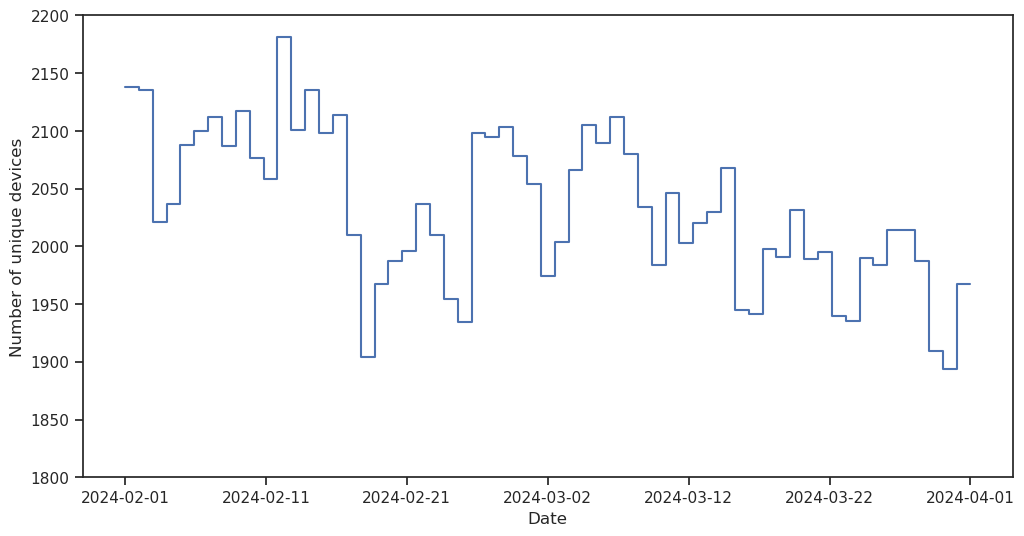

In [76]:

df_dev_per_day['event_date'] = pd.to_datetime(df_dev_per_day['event_date'], format='%Y%m%d')

'''
# Plot the scatter plot of the number of distinct devices
ax1.plot(df_dev_per_day.event_date, df_dev_per_day.number_of_lineage_id, color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('# of distinct devices', color='b')

# Set the date format on the x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Set the y-axis to plain style (remove scientific notation)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax1.yaxis.get_major_formatter().set_scientific(False)
ax1.yaxis.get_major_formatter().set_useOffset(False)

# Add grid, title, and legends
ax1.grid()
plt.title('Number of devices per day')
fig.tight_layout()
'''
sns.set_theme(style="ticks")
#mpl.rcParams['font.family'] = 'verdana'
mpl.rcParams['font.size'] = 50

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_dev_per_day,
    x="event_date",
    weights="number_of_lineage_id",
    bins=len(df_dev_per_day['event_date'].unique()),  # Set bins equal to number of unique days
    kde=False,  # Remove kernel density estimate line
    color="b",
    element="step", 
    fill=False
)


# Format the x-axis to show every 10th date
ax = plt.gca()
xticks = df_dev_per_day['event_date'][::10]
ax.set_xticks(xticks)
ax.set_xticklabels(df_dev_per_day['event_date'].dt.strftime('%Y-%m-%d')[::10], rotation=0, ha='center')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Number of unique devices')

plt.ylim(1800,2200)

# Display the plot
# Save the plot
fig = plt.gcf()
fig.savefig('Images/number_of_devices_per_day.eps', format='eps')

# Display the plot
plt.show()


# Indivual trajectory


In [25]:
config = {
    'version': 'v1',
    'config': {
        'visState': {
            'filters': [],
            'layers': [
                {
                    'id': 'crk0zv',
                    'type': 'point',
                    'config': {
                        'dataId': 'stops points',
                        'label': 'stops points',
                        'color': [0, 0, 255],  # Set to a uniform color (blue in this case)
                        'highlightColor': [252, 242, 26, 255],
                        'columns': {'lat': 'lat', 'lng': 'lng', 'altitude': None},
                        'isVisible': True,
                        'visConfig': {
                            'radius': 30,
                            'fixedRadius': False,
                            'opacity': 0.5,
                            'outline': False,
                            'thickness': 2,
                            'strokeColor': None,
                            'colorRange': None,
                            'strokeColorRange': None,
                            'radiusRange': [0, 50],
                            'filled': True
                        },
                        'hidden': False,
                        'textLabel': [
                            {
                                'field': None,
                                'color': [255, 255, 255],
                                'size': 18,
                                'offset': [0, 0],
                                'anchor': 'start',
                                'alignment': 'center'
                            }
                        ]
                    },
                    'visualChannels': {
                        'colorField': None,
                        'colorScale': 'quantile',
                        'strokeColorField': None,
                        'strokeColorScale': 'quantile',
                        'sizeField': None,
                        'sizeScale': 'linear'
                    }
                },
                {
                    'id': 'vv0kny',
                    'type': 'point',
                    'config': {
                        'dataId': 'stops points subsampled',
                        'label': 'subsampled stops',
                        'color': [0, 0, 255],  # Set to a uniform color (blue in this case)
                        'highlightColor': [252, 242, 26, 255],
                        'columns': {'lat': 'lat', 'lng': 'lng', 'altitude': None},
                        'isVisible': True,
                        'visConfig': {
                            'radius': 25,
                            'fixedRadius': False,
                            'opacity': 0.5,
                            'outline': False,
                            'thickness': 2,
                            'strokeColor': None,
                            'colorRange': None,
                            'strokeColorRange': None,
                            'radiusRange': [0, 50],
                            'filled': True
                        },
                        'hidden': False,
                        'textLabel': [
                            {
                                'field': None,
                                'color': [255, 255, 255],
                                'size': 18,
                                'offset': [0, 0],
                                'anchor': 'start',
                                'alignment': 'center'
                            }
                        ]
                    },
                    'visualChannels': {
                        'colorField': None,
                        'colorScale': 'quantile',
                        'strokeColorField': None,
                        'strokeColorScale': 'quantile',
                        'sizeField': None,
                        'sizeScale': 'linear'
                    }
                },
                {
                    'id': 'y8dl8rc',
                    'type': 'point',
                    'config': {
                        'dataId': 'normal points',
                        'label': 'normal trajectory',
                        'color': [0, 0, 255],  # Set to a uniform color (blue in this case)
                        'highlightColor': [252, 242, 26, 255],
                        'columns': {'lat': 'lat', 'lng': 'lng', 'altitude': None},
                        'isVisible': True,
                        'visConfig': {
                            'radius': 10,
                            'fixedRadius': False,
                            'opacity': 0.5,
                            'outline': False,
                            'thickness': 2,
                            'strokeColor': None,
                            'colorRange': None,
                            'strokeColorRange': None,
                            'radiusRange': [0, 50],
                            'filled': True
                        },
                        'hidden': False,
                        'textLabel': [
                            {
                                'field': None,
                                'color': [255, 255, 255],
                                'size': 18,
                                'offset': [0, 0],
                                'anchor': 'start',
                                'alignment': 'center'
                            }
                        ]
                    },
                    'visualChannels': {
                        'colorField': None,
                        'colorScale': 'quantile',
                        'strokeColorField': None,
                        'strokeColorScale': 'quantile',
                        'sizeField': None,
                        'sizeScale': 'linear'
                    }
                }
            ],
            'interactionConfig': {
                'tooltip': {
                    'fieldsToShow': {
                        'stops points': [
                            {'name': 'data_provider', 'format': None},
                            {'name': 'id_type', 'format': None},
                            {'name': 'lineage_id', 'format': None},
                            {'name': 'event_timestamp', 'format': None},
                            {'name': 'event_zoned_datetime', 'format': None}
                        ],
                        'stops points subsampled': [
                            {'name': 'data_provider', 'format': None},
                            {'name': 'id_type', 'format': None},
                            {'name': 'lineage_id', 'format': None},
                            {'name': 'event_timestamp', 'format': None},
                            {'name': 'event_zoned_datetime', 'format': None}
                        ],
                        'normal points': [
                            {'name': 'data_provider', 'format': None},
                            {'name': 'id_type', 'format': None},
                            {'name': 'lineage_id', 'format': None},
                            {'name': 'event_timestamp', 'format': None},
                            {'name': 'event_zoned_datetime', 'format': None}
                        ]
                    },
                    'compareMode': False,
                    'compareType': 'absolute',
                    'enabled': True
                },
                'brush': {'size': 0.5, 'enabled': False},
                'geocoder': {'enabled': False},
                'coordinate': {'enabled': False}
            },
            'layerBlending': 'normal',
            'splitMaps': [],
            'animationConfig': {'currentTime': None, 'speed': 1}
        },
        'mapState': {
            'bearing': 0,
            'dragRotate': False,
            'latitude': 40.783059084439316,
            'longitude': -73.4173824806252,
            'pitch': 0,
            'zoom': 7.3547620510790015,
            'isSplit': False
        },
        'mapStyle': {
            'styleType': 'dark',
            'topLayerGroups': {},
            'visibleLayerGroups': {
                'label': True,
                'road': True,
                'border': False,
                'building': True,
                'water': True,
                'land': True,
                '3d building': False
            },
            'threeDBuildingColor': [9.665468314072013, 17.18305478057247, 31.1442867897876],
            'mapStyles': {}
        }
    }
}


In [31]:
df_dev_loc_stops = df_dev_loc[(~df_dev_loc.stop_id.isna()) 
                             &(df_dev_loc.subsampled == 0)]

df_dev_loc_stops_sub = df_dev_loc[(~df_dev_loc.stop_id.isna()) 
                             &(df_dev_loc.subsampled == 1)]

df_dev_loc_ = df_dev_loc[(df_dev_loc.stop_id.isna())]

In [32]:
map_towrite = KeplerGl(height=400, config=config)
# map_towrite.add_data(df_dev_loc_stops, name='stops points')
# map_towrite.add_data(df_dev_loc_stops_sub, name='stops points subsampled')
map_towrite.add_data(df_dev_loc_, name='normal points')
map_towrite

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/srv/conda/envs/notebook/lib/python3.9/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'crk0zv', 'type': '…

In [33]:
# this will save current map
map_towrite.save_to_html(file_name='first_map.html')

# this will save map with provided data and config
map_towrite.save_to_html(data={'data_1': df_dev_loc_}, config=config, file_name='first_map.html')

# this will save map with the interaction panel disabled
map_towrite.save_to_html(file_name='first_map.html', read_only=True)

Map saved to first_map.html!
Map saved to first_map.html!
Map saved to first_map.html!


# Stop data

In [83]:
query = f"""
SELECT geohash_6, COUNT(*) as geohash_count
FROM {stops_table_name}
GROUP BY geohash_6
ORDER BY geohash_count DESC
"""

df_geohash_count = %sql $query

print(df_geohash_count.head())

 * trino://localhost:9090/cuebiq/
Done.
  geohash_6  geohash_count
0    dr5ru7           1530
1    dr5rue           1408
2    dr5ru6           1328
3    dr5ru2           1267
4    dr5rud           1239


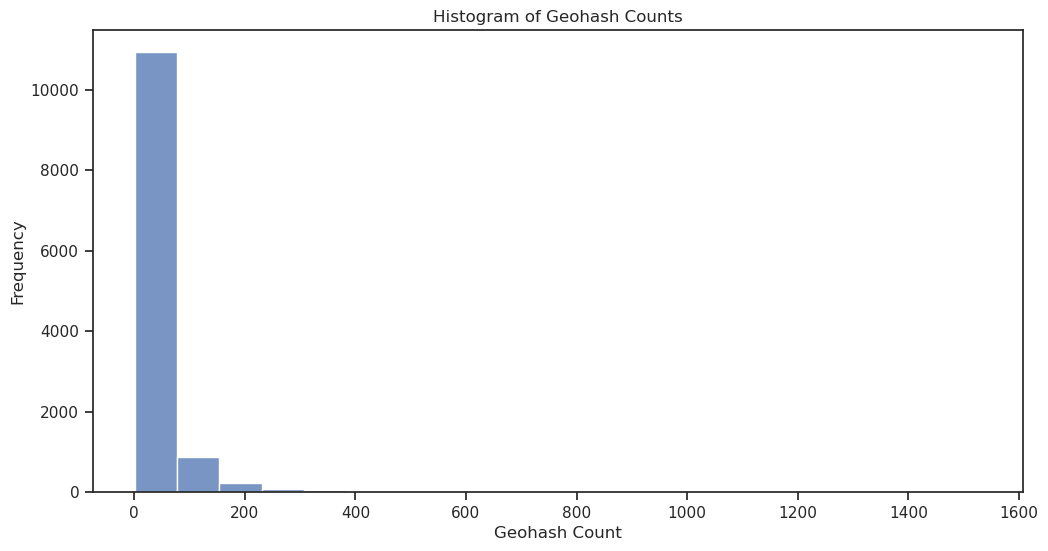

In [84]:
# Plot the histogram of geohash counts
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_geohash_count,
    x='geohash_count',
    bins=20,  # Adjust the number of bins as needed
    kde=False,  # Remove kernel density estimate line
    color='b'
)

# Set labels and title
plt.xlabel('Geohash Count')
plt.ylabel('Frequency')
plt.title('Histogram of Geohash Counts')

# Display the plot
plt.show()

In [46]:
def geohash_to_geojson(geohash):
    # Decode the geohash to get the bounding box
    lat, lon, lat_err, lon_err = geohash2.decode_exactly(geohash)
    lat_min = lat - lat_err
    lat_max = lat + lat_err
    lon_min = lon - lon_err
    lon_max = lon + lon_err

    # Create the GeoJSON polygon
    polygon = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[
                [lon_min, lat_min],
                [lon_min, lat_max],
                [lon_max, lat_max],
                [lon_max, lat_min],
                [lon_min, lat_min]
            ]]
        },
        "properties": {
            "geohash": geohash
        }
    }
    return polygon

query = f"""
select  stop_class,
        substr(stop_geohash, 1, length(stop_geohash) - 3) AS geohash_level_6,
        count (distinct stop_id) as cnt_stops
from {device_location_table_name}
where stop_id is not null
group by 1,2
"""

df_stop_classes = %sql $query
df_stop_classes['geojson'] = df_stop_classes['geohash_level_6'].apply(geohash_to_geojson)

 * trino://localhost:9090/cuebiq/
Done.


In [47]:
config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '5xahcq',
     'type': 'geojson',
     'config': {'dataId': 'Stop class 1',
      'label': 'Stop class 1',
      'color': [255, 254, 230],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geojson'},
      'isVisible': True,
      'visConfig': {'opacity': 0.25,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [255, 153, 31],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': False,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': '1qi0vge',
     'type': 'geojson',
     'config': {'dataId': 'Stop class 2',
      'label': 'Stop class 2',
      'color': [255, 223, 153],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geojson'},
      'isVisible': True,
      'visConfig': {'opacity': 0.56,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [34, 63, 154],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': False,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'fwnj55',
     'type': 'geojson',
     'config': {'dataId': 'Stop class 3',
      'label': 'Stop class 3',
      'color': [245, 113, 65],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geojson'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [18, 92, 119],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': False,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'q04b8p',
     'type': 'geojson',
     'config': {'dataId': 'Stop class 4',
      'label': 'Stop class 4',
      'color': [218, 0, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geojson'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [119, 110, 87],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': False,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'Stop class 1': [{'name': 'stop_class',
        'format': None},
       {'name': 'geohash_level_6', 'format': None}],
      'Stop class 2': [{'name': 'stop_class', 'format': None},
       {'name': 'geohash_level_6', 'format': None}],
      'Stop class 3': [{'name': 'stop_class', 'format': None},
       {'name': 'geohash_level_6', 'format': None}],
      'Stop class 4': [{'name': 'stop_class', 'format': None},
       {'name': 'geohash_level_6', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 40.25417718880347,
   'longitude': -74.18454392785402,
   'pitch': 0,
   'zoom': 6.065762806417463,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [48]:
map_towrite = KeplerGl(height=400, 
                       config=config)
map_towrite.add_data(df_stop_classes[df_stop_classes.stop_class==1], name='Stop class 1')
map_towrite.add_data(df_stop_classes[df_stop_classes.stop_class==2], name='Stop class 2')
map_towrite.add_data(df_stop_classes[df_stop_classes.stop_class==3], name='Stop class 3')
map_towrite.add_data(df_stop_classes[df_stop_classes.stop_class==4], name='Stop class 4')
map_towrite

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '5xahcq', 'type': '…